<a href="https://colab.research.google.com/github/dojun43/Project/blob/main/%EC%8B%A0%EC%9A%A9%EC%B9%B4%EB%93%9C/%5B%EC%A0%84%EC%B2%98%EB%A6%AC%2B%EB%AA%A8%EB%8D%B8%EB%A7%81%5D_%EC%8B%A0%EC%9A%A9%EC%B9%B4%EB%93%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 라이브러리

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 1.2 MB/s 


In [ ]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler 
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import TomekLinks 
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# 데이터 불러오기

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/프로젝트/신용카드 사용자 연체/train.csv')
test = pd.read_csv('/content/drive/MyDrive/프로젝트/신용카드 사용자 연체/test.csv')

# 전처리

## 1. 변수 제거

In [ ]:
train.drop(['index', 'FLAG_MOBIL'], axis=1, inplace=True)
test.drop(['index', 'FLAG_MOBIL'], axis=1, inplace=True)

## 2. DAYS_EMPLOYED(업무 시작일): 양수값 0으로 대체 

In [ ]:
train.loc[(train.DAYS_EMPLOYED > 0), 'DAYS_EMPLOYED'] = 0
test.loc[(test.DAYS_EMPLOYED > 0), 'DAYS_EMPLOYED'] = 0

## 3. 결측치 대체

- Pensioner = 무직으로 대체
- State servant = 분류되지 않은 직업군으로 대체
- Working = 분류되지 않은 직업군으로 대체
- Commercial associate = 분류되지 않은 직업군으로 대체  
- Student = 최빈값으로 대체 -> Core staff

In [ ]:
def fill_na_occyp_type(df):
  df['occyp_type'] = df['occyp_type'].fillna('NaN')

  for i in range(len(df)):
    income_type = df['income_type'][i]
    occyp_type = df['occyp_type'][i]

    if occyp_type == 'NaN':
      if income_type == 'Pensioner':
        df.occyp_type.iloc[i] = 'No job'

      elif income_type == 'State servant' or income_type == 'Working' or income_type == 'Commercial associate':
        df.occyp_type.iloc[i] = 'Unclassified job'

      elif income_type == 'Student':
        df.occyp_type.iloc[i] = 'Core staff'
      
  return df

In [ ]:
train = fill_na_occyp_type(train)
test = fill_na_occyp_type(test)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [ ]:
train.occyp_type.unique()

array(['Unclassified job', 'Laborers', 'Managers', 'Sales staff',
       'High skill tech staff', 'Core staff', 'Drivers', 'Medicine staff',
       'Accountants', 'No job', 'Realty agents', 'Security staff',
       'Cleaning staff', 'Private service staff', 'Cooking staff',
       'Secretaries', 'HR staff', 'IT staff', 'Low-skill Laborers',
       'Waiters/barmen staff'], dtype=object)

In [ ]:
test.occyp_type.unique()

array(['No job', 'Core staff', 'Laborers', 'Drivers', 'Managers',
       'Unclassified job', 'Sales staff', 'Cleaning staff', 'Accountants',
       'Cooking staff', 'Medicine staff', 'Realty agents',
       'Waiters/barmen staff', 'Private service staff',
       'High skill tech staff', 'Low-skill Laborers', 'Security staff',
       'Secretaries', 'HR staff', 'IT staff'], dtype=object)

## 4. 중복 데이터 
- 파생 변수 생성해서 구분

In [ ]:
def create_id(df):
  df['ID'] = \
  df['child_num'].astype(str) + '_' + df['income_total'].astype(str) + '_' +\
  df['DAYS_BIRTH'].astype(str) + '_' + df['DAYS_EMPLOYED'].astype(str) + '_' +\
  df['work_phone'].astype(str) + '_' + df['phone'].astype(str) + '_' +\
  df['email'].astype(str) + '_' + df['family_size'].astype(str) + '_' +\
  df['gender'].astype(str) + '_' + df['car'].astype(str) + '_' +\
  df['reality'].astype(str) + '_' + df['income_type'].astype(str) + '_' +\
  df['edu_type'].astype(str) + '_' + df['family_type'].astype(str) + '_' +\
  df['house_type'].astype(str) + '_' + df['occyp_type'].astype(str)

  return df 

In [ ]:
train = create_id(train)
test = create_id(test)

In [ ]:
train.head()

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,work_phone,phone,email,occyp_type,family_size,begin_month,credit,ID
0,F,N,N,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,-13899,-4709,0,0,0,Unclassified job,2.0,-6.0,1.0,0_202500.0_-13899_-4709_0_0_0_2.0_F_N_N_Commer...
1,F,N,Y,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-11380,-1540,0,0,1,Laborers,3.0,-5.0,1.0,1_247500.0_-11380_-1540_0_0_1_3.0_F_N_Y_Commer...
2,M,Y,Y,0,450000.0,Working,Higher education,Married,House / apartment,-19087,-4434,0,1,0,Managers,2.0,-22.0,2.0,0_450000.0_-19087_-4434_0_1_0_2.0_M_Y_Y_Workin...
3,F,N,Y,0,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-15088,-2092,0,1,0,Sales staff,2.0,-37.0,0.0,0_202500.0_-15088_-2092_0_1_0_2.0_F_N_Y_Commer...
4,F,Y,Y,0,157500.0,State servant,Higher education,Married,House / apartment,-15037,-2105,0,0,0,Managers,2.0,-26.0,2.0,0_157500.0_-15037_-2105_0_0_0_2.0_F_Y_Y_State ...


In [ ]:
test.head()

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,work_phone,phone,email,occyp_type,family_size,begin_month,ID
0,M,Y,N,0,112500.0,Pensioner,Secondary / secondary special,Civil marriage,House / apartment,-21990,0,0,1,0,No job,2.0,-60.0,0_112500.0_-21990_0_0_1_0_2.0_M_Y_N_Pensioner_...
1,F,N,Y,0,135000.0,State servant,Higher education,Married,House / apartment,-18964,-8671,0,1,0,Core staff,2.0,-36.0,0_135000.0_-18964_-8671_0_1_0_2.0_F_N_Y_State ...
2,F,N,Y,0,69372.0,Working,Secondary / secondary special,Married,House / apartment,-15887,-217,1,1,0,Laborers,2.0,-40.0,0_69372.0_-15887_-217_1_1_0_2.0_F_N_Y_Working_...
3,M,Y,N,0,112500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-19270,-2531,1,0,0,Drivers,2.0,-41.0,0_112500.0_-19270_-2531_1_0_0_2.0_M_Y_N_Commer...
4,F,Y,Y,0,225000.0,State servant,Higher education,Married,House / apartment,-17822,-9385,1,0,0,Managers,2.0,-8.0,0_225000.0_-17822_-9385_1_0_0_2.0_F_Y_Y_State ...


## 5. 파생 변수
- DAYS_BIRTH: 연도, 달로 변환한 파생 변수 추가
- DAYS_EMPLOYED: 연도, 달로 변환한 파생 변수 추가

In [ ]:
train['DAYS_BIRTH_year'] = train['DAYS_BIRTH'] // 365 
train['DAYS_BIRTH_month'] = train['DAYS_BIRTH'] // 30 
train['DAYS_EMPLOYED_year'] = train['DAYS_EMPLOYED'] // 365 
train['DAYS_EMPLOYED_month'] = train['DAYS_EMPLOYED'] // 30 

test['DAYS_BIRTH_year'] = test['DAYS_BIRTH'] // 365 
test['DAYS_BIRTH_month'] = test['DAYS_BIRTH'] // 30 
test['DAYS_EMPLOYED_year'] = test['DAYS_EMPLOYED'] // 365 
test['DAYS_EMPLOYED_month'] = test['DAYS_EMPLOYED'] // 30 

In [ ]:
train.head()

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,...,email,occyp_type,family_size,begin_month,credit,ID,DAYS_BIRTH_year,DAYS_BIRTH_month,DAYS_EMPLOYED_year,DAYS_EMPLOYED_month
0,F,N,N,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,-13899,...,0,Unclassified job,2.0,-6.0,1.0,0_202500.0_-13899_-4709_0_0_0_2.0_F_N_N_Commer...,-39,-464,-13,-157
1,F,N,Y,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-11380,...,1,Laborers,3.0,-5.0,1.0,1_247500.0_-11380_-1540_0_0_1_3.0_F_N_Y_Commer...,-32,-380,-5,-52
2,M,Y,Y,0,450000.0,Working,Higher education,Married,House / apartment,-19087,...,0,Managers,2.0,-22.0,2.0,0_450000.0_-19087_-4434_0_1_0_2.0_M_Y_Y_Workin...,-53,-637,-13,-148
3,F,N,Y,0,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-15088,...,0,Sales staff,2.0,-37.0,0.0,0_202500.0_-15088_-2092_0_1_0_2.0_F_N_Y_Commer...,-42,-503,-6,-70
4,F,Y,Y,0,157500.0,State servant,Higher education,Married,House / apartment,-15037,...,0,Managers,2.0,-26.0,2.0,0_157500.0_-15037_-2105_0_0_0_2.0_F_Y_Y_State ...,-42,-502,-6,-71


In [ ]:
test.head()

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,...,phone,email,occyp_type,family_size,begin_month,ID,DAYS_BIRTH_year,DAYS_BIRTH_month,DAYS_EMPLOYED_year,DAYS_EMPLOYED_month
0,M,Y,N,0,112500.0,Pensioner,Secondary / secondary special,Civil marriage,House / apartment,-21990,...,1,0,No job,2.0,-60.0,0_112500.0_-21990_0_0_1_0_2.0_M_Y_N_Pensioner_...,-61,-733,0,0
1,F,N,Y,0,135000.0,State servant,Higher education,Married,House / apartment,-18964,...,1,0,Core staff,2.0,-36.0,0_135000.0_-18964_-8671_0_1_0_2.0_F_N_Y_State ...,-52,-633,-24,-290
2,F,N,Y,0,69372.0,Working,Secondary / secondary special,Married,House / apartment,-15887,...,1,0,Laborers,2.0,-40.0,0_69372.0_-15887_-217_1_1_0_2.0_F_N_Y_Working_...,-44,-530,-1,-8
3,M,Y,N,0,112500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-19270,...,0,0,Drivers,2.0,-41.0,0_112500.0_-19270_-2531_1_0_0_2.0_M_Y_N_Commer...,-53,-643,-7,-85
4,F,Y,Y,0,225000.0,State servant,Higher education,Married,House / apartment,-17822,...,0,0,Managers,2.0,-8.0,0_225000.0_-17822_-9385_1_0_0_2.0_F_Y_Y_State ...,-49,-595,-26,-313


## 6. Label encoding

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26457 entries, 0 to 26456
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   gender               26457 non-null  object 
 1   car                  26457 non-null  object 
 2   reality              26457 non-null  object 
 3   child_num            26457 non-null  int64  
 4   income_total         26457 non-null  float64
 5   income_type          26457 non-null  object 
 6   edu_type             26457 non-null  object 
 7   family_type          26457 non-null  object 
 8   house_type           26457 non-null  object 
 9   DAYS_BIRTH           26457 non-null  int64  
 10  DAYS_EMPLOYED        26457 non-null  int64  
 11  work_phone           26457 non-null  int64  
 12  phone                26457 non-null  int64  
 13  email                26457 non-null  int64  
 14  occyp_type           26457 non-null  object 
 15  family_size          26457 non-null 

In [ ]:
#id 값 합치기 
ID_df = pd.concat([train['ID'], test['ID']])

#encoder 생성 
gender_encoder = LabelEncoder().fit(train['gender'])
car_encoder = LabelEncoder().fit(train['car'])
reality_encoder = LabelEncoder().fit(train['reality'])
income_type_encoder = LabelEncoder().fit(train['income_type'])
edu_type_encoder = LabelEncoder().fit(train['edu_type'])
family_type_encoder = LabelEncoder().fit(train['family_type'])
house_type_encoder = LabelEncoder().fit(train['house_type'])
occyp_type_encoder = LabelEncoder().fit(train['occyp_type'])
ID_encoder = LabelEncoder().fit(ID_df)

#train encoding
train['gender'] = gender_encoder.transform(train['gender'])
train['car'] = car_encoder.transform(train['car'])
train['reality'] = reality_encoder.transform(train['reality'])
train['income_type'] = income_type_encoder.transform(train['income_type'])
train['edu_type'] = edu_type_encoder.transform(train['edu_type'])
train['family_type'] = family_type_encoder.transform(train['family_type'])
train['house_type'] = house_type_encoder.transform(train['house_type'])
train['occyp_type'] = occyp_type_encoder.transform(train['occyp_type'])
train['ID'] = ID_encoder.transform(train['ID'])

#test encoding
test['gender'] = gender_encoder.transform(test['gender'])
test['car'] = car_encoder.transform(test['car'])
test['reality'] = reality_encoder.transform(test['reality'])
test['income_type'] = income_type_encoder.transform(test['income_type'])
test['edu_type'] = edu_type_encoder.transform(test['edu_type'])
test['family_type'] = family_type_encoder.transform(test['family_type'])
test['house_type'] = house_type_encoder.transform(test['house_type'])
test['occyp_type'] = occyp_type_encoder.transform(test['occyp_type'])
test['ID'] = ID_encoder.transform(test['ID'])

In [ ]:
train.head()

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,...,email,occyp_type,family_size,begin_month,credit,ID,DAYS_BIRTH_year,DAYS_BIRTH_month,DAYS_EMPLOYED_year,DAYS_EMPLOYED_month
0,0,0,0,0,202500.0,0,1,1,2,-13899,...,0,18,2.0,-6.0,1.0,3454,-39,-464,-13,-157
1,0,0,1,1,247500.0,0,4,0,1,-11380,...,1,8,3.0,-5.0,1.0,8118,-32,-380,-5,-52
2,1,1,1,0,450000.0,4,1,1,1,-19087,...,0,10,2.0,-22.0,2.0,5628,-53,-637,-13,-148
3,0,0,1,0,202500.0,0,4,1,1,-15088,...,0,15,2.0,-37.0,0.0,3490,-42,-503,-6,-70
4,0,1,1,0,157500.0,2,1,1,1,-15037,...,0,10,2.0,-26.0,2.0,2127,-42,-502,-6,-71


In [ ]:
test.head()

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,...,phone,email,occyp_type,family_size,begin_month,ID,DAYS_BIRTH_year,DAYS_BIRTH_month,DAYS_EMPLOYED_year,DAYS_EMPLOYED_month
0,1,1,0,0,112500.0,1,4,0,1,-21990,...,1,0,12,2.0,-60.0,547,-61,-733,0,0
1,0,0,1,0,135000.0,2,1,1,1,-18964,...,1,0,3,2.0,-36.0,1414,-52,-633,-24,-290
2,0,0,1,0,69372.0,4,4,1,1,-15887,...,1,0,8,2.0,-40.0,6014,-44,-530,-1,-8
3,1,1,0,0,112500.0,0,4,1,1,-19270,...,0,0,4,2.0,-41.0,399,-53,-643,-7,-85
4,0,1,1,0,225000.0,2,1,1,1,-17822,...,0,0,10,2.0,-8.0,4145,-49,-595,-26,-313


# Train/Test 분할 

In [ ]:
X = train.drop(['credit'], axis=1)
y = train['credit']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=1004)

In [ ]:
# train set, test set 분할 후 shape 
x_train_shape = np.shape(X_train)
y_train_shape = np.shape(y_train)
x_test_shape = np.shape(X_test)
y_test_shape = np.shape(y_test)

print('X_train:',x_train_shape, 'y_train:',y_train_shape)
print('X_test:',x_test_shape, 'y_test:',y_test_shape)

X_train: (21165, 22) y_train: (21165,)
X_test: (5292, 22) y_test: (5292,)


# 데이터 불균형

## 1. Random Under Sample

In [ ]:
RU_X, RU_y = RandomUnderSampler(random_state=0).fit_resample(X_train, y_train)

In [ ]:
RU_X

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,...,phone,email,occyp_type,family_size,begin_month,ID,DAYS_BIRTH_year,DAYS_BIRTH_month,DAYS_EMPLOYED_year,DAYS_EMPLOYED_month
0,1,1,1,2,225000.0,0,4,1,1,-16084,...,0,0,8,4.0,-42.0,9269,-45,-537,-4,-47
1,1,0,1,0,270000.0,0,4,1,1,-14896,...,0,1,4,2.0,-53.0,4748,-41,-497,-15,-181
2,0,0,0,0,67500.0,4,4,1,1,-18549,...,0,0,18,2.0,-52.0,5879,-51,-619,-4,-39
3,0,0,1,0,99000.0,2,1,1,2,-23395,...,1,0,3,2.0,-19.0,6815,-65,-780,-1,-6
4,1,0,0,1,202500.0,4,3,0,1,-14454,...,1,0,4,3.0,-30.0,7863,-40,-482,-3,-36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7768,0,0,1,0,157500.0,0,1,1,1,-18384,...,1,0,18,2.0,-41.0,2266,-51,-613,-3,-27
7769,0,0,1,0,225000.0,1,4,0,1,-22084,...,0,0,12,2.0,-15.0,4295,-61,-737,0,0
7770,0,0,1,0,135000.0,4,4,1,1,-24449,...,1,0,11,2.0,-47.0,1711,-67,-815,-9,-102
7771,0,0,1,0,202500.0,0,1,3,0,-12196,...,0,0,0,1.0,-39.0,3415,-34,-407,-7,-74


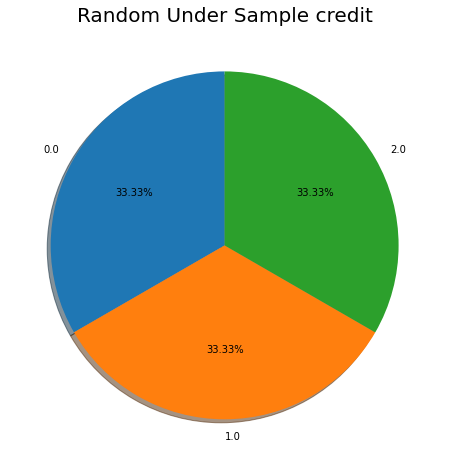

In [ ]:
plt.subplots(figsize = (8,8))
plt.pie(RU_y.value_counts(), labels = RU_y.value_counts().index, 
        autopct="%.2f%%", shadow = True, startangle = 90)
plt.title('Random Under Sample credit', size=20)
plt.show()

## 2. Random Over Sample

In [ ]:
RO_X, RO_y = RandomOverSampler(random_state=0).fit_resample(X_train, y_train)

In [ ]:
RO_X

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,...,phone,email,occyp_type,family_size,begin_month,ID,DAYS_BIRTH_year,DAYS_BIRTH_month,DAYS_EMPLOYED_year,DAYS_EMPLOYED_month
0,0,0,1,0,67500.0,4,4,1,1,-19620,...,0,0,3,2.0,-48.0,5899,-54,-654,-7,-74
1,1,1,1,2,225000.0,0,4,1,1,-16084,...,0,0,8,4.0,-42.0,9269,-45,-537,-4,-47
2,1,1,0,0,247500.0,0,1,1,1,-16269,...,0,0,4,2.0,-23.0,4482,-45,-543,-3,-27
3,0,1,1,1,225000.0,4,1,2,1,-14816,...,0,0,3,2.0,-25.0,8040,-41,-494,-5,-56
4,1,0,0,0,270000.0,4,2,1,1,-14279,...,1,0,4,2.0,-32.0,4735,-40,-476,-6,-72
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40666,1,1,1,0,207000.0,1,1,1,1,-24312,...,0,0,12,2.0,-32.0,3789,-67,-811,0,0
40667,0,0,1,0,135000.0,4,4,4,1,-21977,...,0,0,6,1.0,-17.0,1606,-61,-733,-26,-315
40668,1,1,1,0,180000.0,4,1,1,1,-15444,...,0,0,16,2.0,-45.0,2895,-43,-515,-2,-14
40669,1,0,0,1,180000.0,4,4,1,1,-10054,...,1,1,4,3.0,-1.0,7595,-28,-336,-2,-20


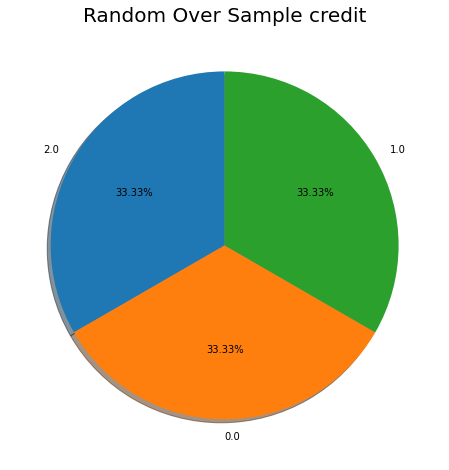

In [ ]:
plt.subplots(figsize = (8,8))
plt.pie(RO_y.value_counts(), labels = RO_y.value_counts().index, 
        autopct="%.2f%%", shadow = True, startangle = 90)
plt.title('Random Over Sample credit', size=20)
plt.show()

## 3. TomekLinks 

In [ ]:
TO_X, TO_y = TomekLinks(sampling_strategy='majority').fit_resample(X_train, y_train)

In [ ]:
TO_X

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,...,phone,email,occyp_type,family_size,begin_month,ID,DAYS_BIRTH_year,DAYS_BIRTH_month,DAYS_EMPLOYED_year,DAYS_EMPLOYED_month
0,0,0,1,0,67500.0,4,4,1,1,-19620,...,0,0,3,2.0,-48.0,5899,-54,-654,-7,-74
1,1,1,1,2,225000.0,0,4,1,1,-16084,...,0,0,8,4.0,-42.0,9269,-45,-537,-4,-47
2,1,1,0,0,247500.0,0,1,1,1,-16269,...,0,0,4,2.0,-23.0,4482,-45,-543,-3,-27
3,0,1,1,1,225000.0,4,1,2,1,-14816,...,0,0,3,2.0,-25.0,8040,-41,-494,-5,-56
4,0,0,1,0,112500.0,4,1,0,1,-10443,...,0,0,3,2.0,-54.0,126,-29,-349,-2,-19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19503,0,1,1,0,306000.0,4,1,1,1,-13505,...,0,0,10,2.0,-17.0,5072,-37,-451,-4,-42
19504,0,0,1,1,112500.0,4,4,0,1,-13541,...,0,0,3,3.0,-43.0,6932,-38,-452,-10,-115
19505,0,0,1,0,117000.0,4,4,1,1,-9409,...,0,0,8,2.0,-50.0,762,-26,-314,-3,-35
19506,0,0,1,0,130500.0,1,1,0,1,-21461,...,0,0,12,2.0,-9.0,982,-59,-716,0,0


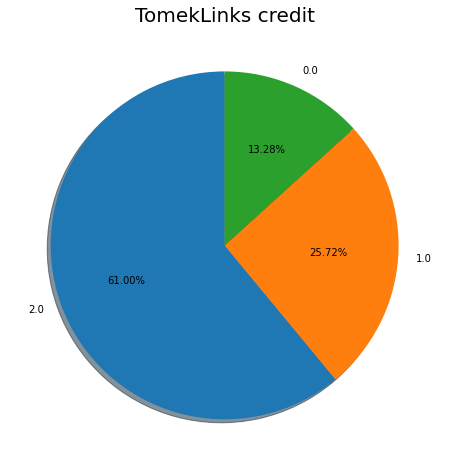

In [ ]:
plt.subplots(figsize = (8,8))
plt.pie(TO_y.value_counts(), labels = TO_y.value_counts().index, 
        autopct="%.2f%%", shadow = True, startangle = 90)
plt.title('TomekLinks credit', size=20)
plt.show()

## 4. SMOTE

In [ ]:
SM_X, SM_y = SMOTETomek(random_state=4).fit_resample(X_train, y_train)

In [ ]:
SM_X

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,...,phone,email,occyp_type,family_size,begin_month,ID,DAYS_BIRTH_year,DAYS_BIRTH_month,DAYS_EMPLOYED_year,DAYS_EMPLOYED_month
0,0,0,1,0,67500.0,4,4,1,1,-19620,...,0,0,3,2.000000,-48.000000,5899,-54,-654,-7,-74
1,1,1,1,2,225000.0,0,4,1,1,-16084,...,0,0,8,4.000000,-42.000000,9269,-45,-537,-4,-47
2,0,1,1,1,225000.0,4,1,2,1,-14816,...,0,0,3,2.000000,-25.000000,8040,-41,-494,-5,-56
3,0,0,1,0,112500.0,4,1,0,1,-10443,...,0,0,3,2.000000,-54.000000,126,-29,-349,-2,-19
4,0,0,1,0,112500.0,1,4,1,1,-22396,...,0,0,12,2.000000,-13.000000,571,-62,-747,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36114,0,0,0,0,72000.0,4,4,3,1,-19580,...,0,0,1,1.000000,-16.739863,6028,-54,-653,-5,-63
36115,0,0,1,2,202500.0,4,2,1,1,-13532,...,1,0,12,4.532457,-7.935085,9427,-37,-451,-10,-116
36116,0,1,1,0,270000.0,4,4,2,1,-16971,...,0,0,18,1.000000,-28.193265,4798,-47,-566,-2,-13
36117,0,1,0,2,135000.0,4,1,1,1,-13332,...,0,0,2,4.733240,-37.132680,9413,-37,-444,-13,-154


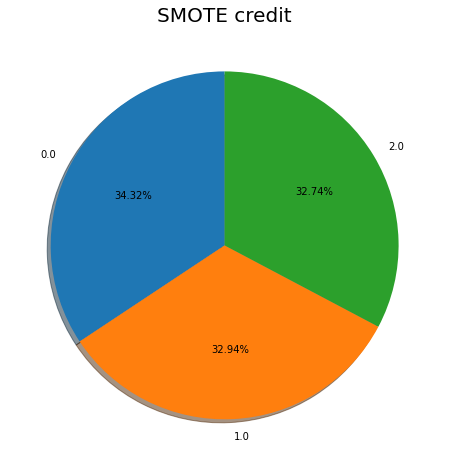

In [ ]:
plt.subplots(figsize = (8,8))
plt.pie(SM_y.value_counts(), labels = SM_y.value_counts().index, 
        autopct="%.2f%%", shadow = True, startangle = 90)
plt.title('SMOTE credit', size=20)
plt.show()

## 5. SMOTE+Tomek

In [ ]:
ST_X, ST_y = SMOTETomek(random_state=4).fit_resample(X_train, y_train)

In [ ]:
ST_X

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,...,phone,email,occyp_type,family_size,begin_month,ID,DAYS_BIRTH_year,DAYS_BIRTH_month,DAYS_EMPLOYED_year,DAYS_EMPLOYED_month
0,0,0,1,0,67500.0,4,4,1,1,-19620,...,0,0,3,2.000000,-48.000000,5899,-54,-654,-7,-74
1,1,1,1,2,225000.0,0,4,1,1,-16084,...,0,0,8,4.000000,-42.000000,9269,-45,-537,-4,-47
2,0,1,1,1,225000.0,4,1,2,1,-14816,...,0,0,3,2.000000,-25.000000,8040,-41,-494,-5,-56
3,0,0,1,0,112500.0,4,1,0,1,-10443,...,0,0,3,2.000000,-54.000000,126,-29,-349,-2,-19
4,0,0,1,0,112500.0,1,4,1,1,-22396,...,0,0,12,2.000000,-13.000000,571,-62,-747,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36114,0,0,0,0,72000.0,4,4,3,1,-19580,...,0,0,1,1.000000,-16.739863,6028,-54,-653,-5,-63
36115,0,0,1,2,202500.0,4,2,1,1,-13532,...,1,0,12,4.532457,-7.935085,9427,-37,-451,-10,-116
36116,0,1,1,0,270000.0,4,4,2,1,-16971,...,0,0,18,1.000000,-28.193265,4798,-47,-566,-2,-13
36117,0,1,0,2,135000.0,4,1,1,1,-13332,...,0,0,2,4.733240,-37.132680,9413,-37,-444,-13,-154


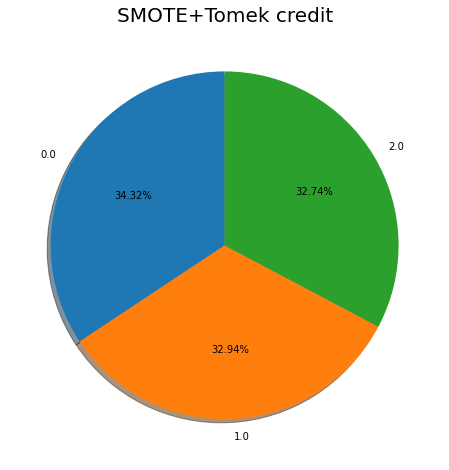

In [ ]:
plt.subplots(figsize = (8,8))
plt.pie(ST_y.value_counts(), labels = ST_y.value_counts().index, 
        autopct="%.2f%%", shadow = True, startangle = 90)
plt.title('SMOTE+Tomek credit', size=20)
plt.show()

Text(0, 0.5, 'Sampling')

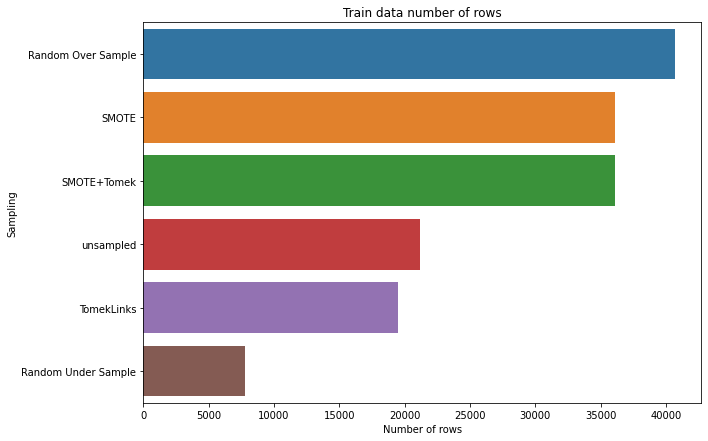

In [ ]:
df = pd.DataFrame({
                   'sampling':['unsampled','Random Under Sample', 'Random Over Sample', 'TomekLinks', 'SMOTE', 'SMOTE+Tomek'],
                   'data_len':[len(y_train), len(RU_y), len(RO_y), len(TO_y), len(SM_y), len(ST_y)]
                   })

df.sort_values(by=['data_len'], ascending=False,inplace=True)

plt.figure(figsize=(10,7))

sns.barplot(x=df['data_len'], y=df['sampling'])

plt.title('Train data number of rows')
plt.xlabel('Number of rows')
plt.ylabel('Sampling')

# 모델링

## 1. K-Fold Cross-Validation

In [ ]:
folds = KFold(n_splits = 15, shuffle = True, random_state = 100)

In [ ]:
folds

KFold(n_splits=15, random_state=100, shuffle=True)

## LGBM

- gird search로 하이퍼 파라미터 최적화 

In [ ]:
'''
model=LGBMClassifier()

#최적화할 파라미터 범위 
lgbm_params = {
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [8, 12, 16],
    'n_estimator': [25, 50, 100],
}

grid_lgbm = GridSearchCV(model, param_grid=lgbm_params, scoring = 'accuracy', cv=folds, n_jobs=-1)
grid_lgbm.fit(RO_X, RO_y)
'''

''

In [ ]:
'''
print('best params:\n', grid_lgbm.best_params_)
print('best score:', grid_lgbm.best_score_)
'''

best params:
 {'learning_rate': 0.2, 'max_depth': 12, 'n_estimator': 25}
best score: 0.7116127184234665


- 최적화한 모델 생성

In [ ]:
# unsampled lgbm model
unsampled_lgbm_model = LGBMClassifier(max_depth=12, n_estimator=25, learning_rate=0.2, verbose=0)
unsampled_lgbm_model.fit(X_train, y_train)

# random under sample lgbm model
RU_lgbm_model = LGBMClassifier(max_depth=12, n_estimator=25, learning_rate=0.2, verbose=0)
RU_lgbm_model.fit(RU_X, RU_y)

# random over sample lgbm model
RO_lgbm_model = LGBMClassifier(max_depth=12, n_estimator=25, learning_rate=0.2, verbose=0)
RO_lgbm_model.fit(RO_X, RO_y)

# TomekLinks lgbm model
TO_lgbm_model = LGBMClassifier(max_depth=16, n_estimator=25, learning_rate=0.2, verbose=0)
TO_lgbm_model.fit(TO_X, TO_y)

# SMOTE lgbm model
SM_lgbm_model = LGBMClassifier(max_depth=20, n_estimator=25, learning_rate=0.2, verbose=0)
SM_lgbm_model.fit(SM_X, SM_y)

# SMOTE+Tomek lgbm model
ST_lgbm_model = LGBMClassifier(max_depth=20, n_estimator=25, learning_rate=0.2, verbose=0)
ST_lgbm_model.fit(ST_X, ST_y)

LGBMClassifier(learning_rate=0.2, max_depth=20, n_estimator=25, verbose=0)

## Catboost

- gird search로 하이퍼 파라미터 최적화

In [ ]:
'''
#모델 생성
model=CatBoostClassifier()

#최적화할 파라미터 범위 
cb_params = {'learning_rate': [0.1],
             'depth': [10],
             'l2_leaf_reg': [5]
            }

grid_cb = GridSearchCV(model, param_grid=cb_params, scoring = 'accuracy', cv=folds, n_jobs=-1)
grid_cb.fit(X, y)
'''

In [ ]:
'''
print('best params:\n', grid_cb.best_params_)
print('best score:', grid_cb.best_score_)
'''

- 최적화한 모델 생성

In [ ]:
# unsampled catboost model
unsampled_cat_model = CatBoostClassifier(depth=10, l2_leaf_reg=5, learning_rate=0.1, verbose=0)
unsampled_cat_model.fit(X_train, y_train)

# random under sample catboost model
RU_cat_model = CatBoostClassifier(depth=10, l2_leaf_reg=5, learning_rate=0.1, verbose=0)
RU_cat_model.fit(RU_X, RU_y)

# random over sample catboost model
RO_cat_model = CatBoostClassifier(depth=10, l2_leaf_reg=5, learning_rate=0.1, verbose=0)
RO_cat_model.fit(RO_X, RO_y)

# TomekLinks catboost model
TO_cat_model = CatBoostClassifier(depth=10, l2_leaf_reg=5, learning_rate=0.1, verbose=0)
TO_cat_model.fit(TO_X, TO_y)

# SMOTE catboost model
SM_cat_model = CatBoostClassifier(depth=10, l2_leaf_reg=5, learning_rate=0.1, verbose=0)
SM_cat_model.fit(SM_X, SM_y)

# SMOTE+Tomek catboost model
ST_cat_model = CatBoostClassifier(depth=10, l2_leaf_reg=5, learning_rate=0.1, verbose=0)
ST_cat_model.fit(ST_X, ST_y)

# 성능 평가

In [ ]:
from sklearn.metrics import log_loss 
from sklearn.metrics import accuracy_score

In [ ]:
def create_score_df(model_name, model, X_train, y_train, X_test, y_test):
  pred_train = model.predict(X_train)
  train_accuracy = accuracy_score(y_train, pred_train)

  pred_proba_train = model.predict_proba(X_train)
  train_logloss = log_loss(y_train, pred_proba_train)

  pred_test = model.predict(X_test)
  test_accuracy = accuracy_score(y_test, pred_test)

  pred_proba_test = model.predict_proba(X_test)
  test_logloss = log_loss(y_test, pred_proba_test)

  score_df = pd.DataFrame({
                           'model':[model_name],
                           'train_accuracy_score':[train_accuracy], 
                           'train_log_loss':[train_logloss],
                           'test_accuracy_score':[test_accuracy],
                           'test_log_loss':[test_logloss]
                           })
  
  return score_df

In [ ]:
score_df = pd.DataFrame({'model':[],'train_log_loss':[],'train_accuracy_score':[], 'test_log_loss':[], 'test_accuracy_score':[]})

model_name_list = ['unsampled lgbm', 'random under sample lgbm', 'random over sample lgbm', 'TomekLinks lgbm', 'SMOTE lgbm', 'SMOTE+Tomek lgbm',
                  'unsampled catboost', 'random under sample catboost', 'random over sample catboost', 'TomekLinks catboost', 'SMOTE catboost', 'SMOTE+Tomek catboost'] 

model_list = [unsampled_lgbm_model, RU_lgbm_model, RO_lgbm_model, TO_lgbm_model, SM_lgbm_model, ST_lgbm_model, 
              unsampled_cat_model, RU_cat_model, RO_cat_model, TO_cat_model, SM_cat_model, ST_cat_model]

X_train_list = [X_train, RU_X, RO_X, TO_X, SM_X, ST_X,
                X_train, RU_X, RO_X, TO_X, SM_X, ST_X]

y_train_list = [y_train, RU_y, RO_y, TO_y, SM_y, ST_y,
                y_train, RU_y, RO_y, TO_y, SM_y, ST_y]

for model_name, model, X_train, y_train in zip(model_name_list, model_list, X_train_list, y_train_list):
  new_df = create_score_df(model_name, model, X_train, y_train, X_test, y_test)
  score_df = score_df.append(new_df, ignore_index=True)

In [ ]:
score_df

,model,train_log_loss,train_accuracy_score,test_log_loss,test_accuracy_score
0,unsampled lgbm,0.547070,0.823196,0.783531,0.694444
1,random under sample lgbm,0.635332,0.832497,0.986690,0.515306
2,random over sample lgbm,0.714012,0.778196,0.888298,0.626039
3,TomekLinks lgbm,0.595855,0.749590,0.739922,0.707861
4,SMOTE lgbm,0.543506,0.826269,0.777948,0.701436
5,SMOTE+Tomek lgbm,0.543506,0.826269,0.777948,0.701436
6,unsampled catboost,0.249454,0.949417,0.818240,0.680650
7,random under sample catboost,0.242777,0.969510,1.079068,0.506803
8,random over sample catboost,0.255441,0.949497,0.830888,0.673469
9,TomekLinks catboost,0.286410,0.922647,0.782284,0.689720


In [ ]:
def plot_feature_importance(importance, names, title):
    
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    plt.figure(figsize=(10,8))

    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])

    plt.title(title)
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')

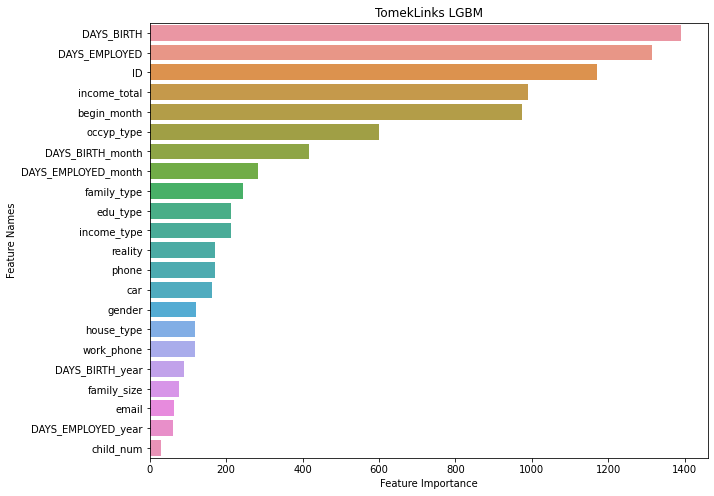

In [ ]:
plot_feature_importance(TO_lgbm_model.feature_importances_, X.columns, 'TomekLinks LGBM')

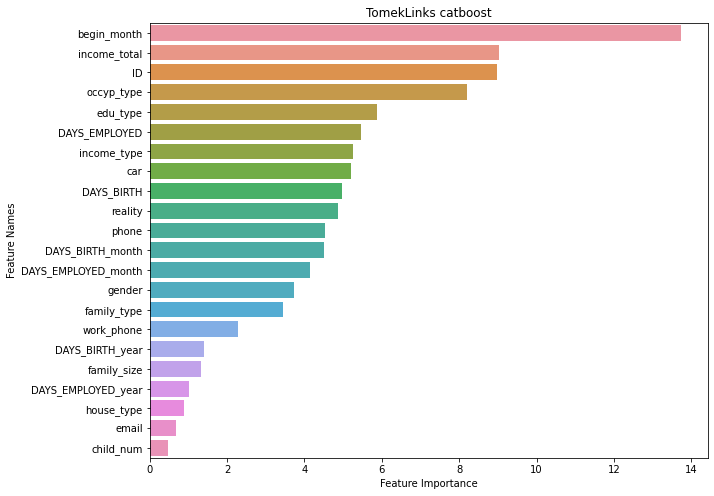

In [ ]:
plot_feature_importance(TO_cat_model.get_feature_importance(), X.columns, 'TomekLinks catboost')

# Submission

In [ ]:
submission = pd.read_csv('/content/drive/MyDrive/프로젝트/신용카드 사용자 연체/sample_submission.csv')

In [ ]:
submission.head()

,index,0,1,2
0,26457,0,0,0
1,26458,0,0,0
2,26459,0,0,0
3,26460,0,0,0
4,26461,0,0,0


In [ ]:
test_pred = TO_lgbm_model.predict_proba(test)

In [ ]:
submission.iloc[:, 1:] = test_pred
submission

,index,0,1,2
0,26457,0.129782,0.099916,0.770302
1,26458,0.183413,0.204350,0.612238
2,26459,0.048136,0.156934,0.794930
3,26460,0.165978,0.239565,0.594457
4,26461,0.085438,0.101929,0.812634
...,...,...,...,...
9995,36452,0.164351,0.261917,0.573732
9996,36453,0.094281,0.331323,0.574396
9997,36454,0.023527,0.120161,0.856312
9998,36455,0.055209,0.128558,0.816233


In [ ]:
#submission.to_csv('submission_0523.csv', index=False)